In [ ]:
from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw

In [1]:
def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


## Import the necessary software libraries:

In [3]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

## Create and prepare the environment

### Create the environment

C:\Users\nimah\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


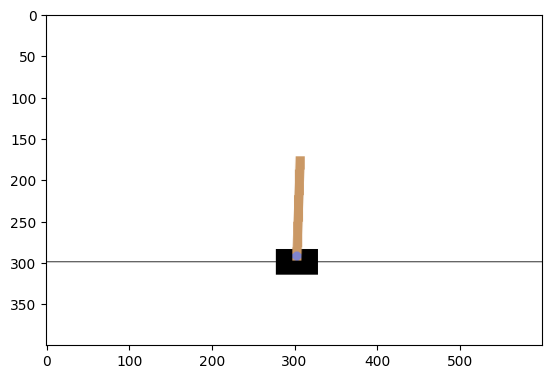

In [6]:
env = gym.make('CartPole-v0')
seed_everything(env)
env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [7]:
state_dims = env.observation_space.shape[0] #state dimentions: 4 values: position of the cart, speed of the cart, angle of the pole, and the speed of which that the pole falls.
num_actions = env.action_space.n #action space
print(f"state space: {state_dims} , action space: {num_actions}")

state space: 4 , action space: 2


### Prepare the environment to work with PyTorch

In [9]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()

    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [10]:
env = PreprocessEnv(env)

In [11]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-0.0406,  0.0476,  0.0261,  0.0286]])
Next state: tensor([[-0.0396, -0.1479,  0.0267,  0.3294]]), Reward: tensor([[1.]]), Done: tensor([[False]])


[link text](https://)## Create the Q-Network and policy

<br><br>

### Create the Q-Network: $\hat q(s,a| \theta)$

In [14]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [16]:
target_q_network =  copy.deepcopy(q_network).eval()


### Create the exploratory policy: $b(s)$

In [18]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>


In [20]:
class ReplayMemory:

    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

## Implement the algorithm

</br></br>

In [22]:
def deep_q_learning(q_network, policy, episodes, alpha=0.0001, batch_size=32, gamma=0.99, epsilon=0.2):
  optim = AdamW(q_network.parameters(), lr=alpha)
  memory = ReplayMemory()
  stats = {'MSE Loss' : [],'Returns' : []}

  for episode in tqdm(range(1, episodes + 1)):
    state = env.reset()
    done = False
    #compute the return of each episode:
    ep_return = 0

    while not done:
      action = policy(state, epsilon)
      next_state, reward, done, _ = env.step(action)
      memory.insert([state, action, reward,done, next_state])

      if memory.can_sample(batch_size):
        state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
        #q values for the current state
        qsa_b = q_network(state_b).gather(1, action_b)
        #q values for the next sates:
        next_qsa_b = target_q_network(next_state_b)
        #select the highest q value:
        next_qsa_b = torch.max(next_qsa_b,dim=-1, keepdim=True)[0]

        target_b = reward_b + ~done_b * gamma * next_qsa_b
        loss = F.mse_loss(qsa_b, target_b)

        #wipe gradiants from nn:
        q_network.zero_grad()
        #update nn:
        loss.backward()
        optim.step()

        stats['MSE Loss'].append(loss.item())

      state = next_state
      ep_return += reward.item()

    stats['Returns'].append(ep_return)

    #every 10 episodes update the target nn
    if episode % 10 == 0 :
      target_q_network.load_state_dict(q_network.state_dict())

  return stats


In [29]:
stats = deep_q_learning(q_network, policy, 500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.04it/s]


In [30]:
window_size = 500
y_smooth = np.convolve(stats['MSE Loss'], np.ones(window_size)/window_size, mode='valid')

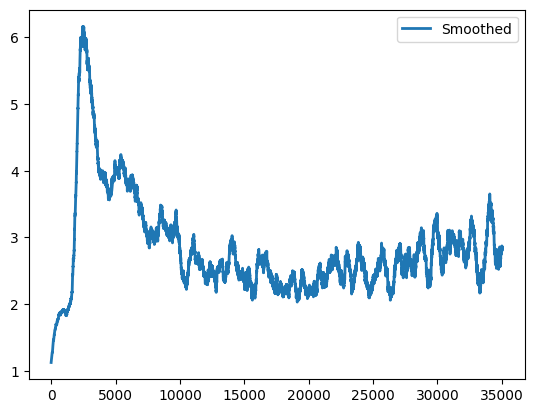

In [33]:
plt.plot(np.arange(y_smooth.size), y_smooth, label='Smoothed', linewidth=2)
plt.legend()
plt.show()

## Show results

### Plot execution stats

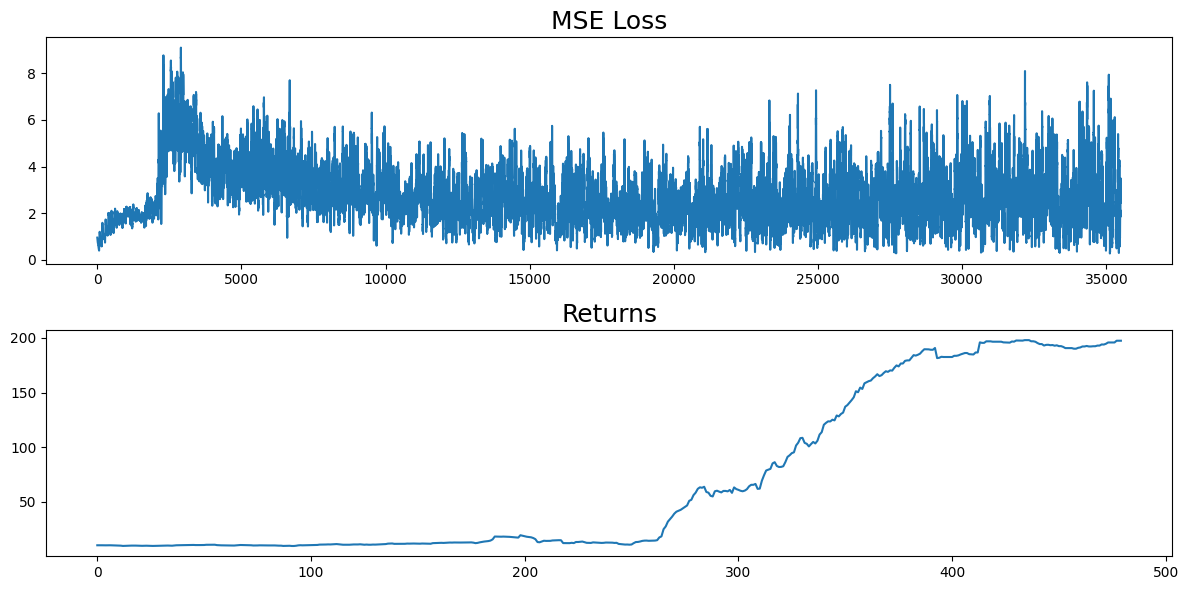

In [35]:
plot_stats(stats)

### Test the resulting agent

In [38]:
test_agent(env, policy, episodes=1)

C:\Users\nimah\AppData\Local\Temp\ipykernel_36484\3690590741.py:35: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)


## Resources

[[1] Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)